# Importing Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, Dataset
from transformers import RobertaTokenizer, RobertaModel
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from tqdm import tqdm
import os
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import wordnet

nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

# Device Configuration

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

Using device: cuda


# Dataset Preprocessing

In [3]:
def clean_text(text):
    # text = str(text).lower()                              # lowercase
    text = re.sub(r"<.*?>", " ", text)                    # remove HTML tags
    text = re.sub(r"http\S+|www\S+|https\S+", " ", text)  # remove URLs
    text = re.sub(r"[^a-zA-Z\s]", "", text)               # remove special chars
    text = re.sub(r"\s+", " ", text)                      # remove extra spaces
    text = " ".join([word for word in text.split() if word not in STOPWORDS])  # remove stopwords
    return text.strip()



# Tokenization and RoBERTa Classifier

In [4]:
# Tokenizer
TOKENIZER = RobertaTokenizer.from_pretrained("roberta-base")

# Dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Model
class RobertaClassifier(nn.Module):
    def __init__(self, num_classes):
        super(RobertaClassifier, self).__init__()
        self.roberta = RobertaModel.from_pretrained("roberta-base")
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(self.roberta.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]  # CLS token
        x = self.dropout(pooled_output)
        return self.fc(x)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

# Load Data

In [5]:
# Load data
def load_data():
    train_df = pd.read_csv("/kaggle/input/8-to-8-thon/train.csv")
    test_df = pd.read_csv("/kaggle/input/8-to-8-thon/test.csv")
    train_texts = train_df["text"].tolist()
    train_labels = train_df["generated"].tolist()
    test_texts = test_df["text"].tolist()
    test_ids = test_df["id"].tolist()


    X_train, X_val, y_train, y_val = train_test_split(train_texts, train_labels, test_size=0.1, random_state=42)

    return X_train, y_train, X_val, y_val, test_texts, test_ids


# Training Function

In [6]:
from torch.cuda.amp import autocast, GradScaler

# Training function with mixed precision
def train_model(model, train_loader, val_loader, epochs=20, learning_rate=2e-5):
    model.to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    scaler = GradScaler()  # Helps with fp16 training

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            optimizer.zero_grad()

            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            labels = batch["labels"].to(DEVICE)

            with autocast():  # Enable fp16 precision
                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()  # Scale loss for stability
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_losses.append(total_loss / len(train_loader))
        train_accuracies.append(correct / total)

        val_loss, val_acc = evaluate_model(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}: Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)


# Evaluation

In [7]:
# Evaluation
def evaluate_model(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            labels = batch["labels"].to(DEVICE)
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    plot_confusion_matrix(all_labels, all_preds)
    print(classification_report(all_labels, all_preds))
    return total_loss / len(loader), correct / total


# Visualization

In [8]:
# Visualizations
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Val Loss")
    plt.title("Loss Curve")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Train Acc")
    plt.plot(epochs, val_accuracies, label="Val Acc")
    plt.title("Accuracy Curve")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()


# Prediction on Test Data

In [9]:
# Predict on test
def predict_and_save(model, test_texts, test_ids):
    model.eval()
    predictions = []
    with torch.no_grad():
        for text in tqdm(test_texts, desc="Predicting"):
            encoding = TOKENIZER(text, truncation=True, padding="max_length", max_length=128, return_tensors="pt").to(DEVICE)
            outputs = model(encoding["input_ids"], encoding["attention_mask"])
            pred_label = torch.argmax(outputs).item()
            predictions.append(pred_label)

    pd.DataFrame({"id": test_ids, "generated": predictions}).to_csv("submission.csv", index=False)
    print("Saved predictions to submission.csv")

# RoBERTa with XGBoost

In [10]:
# RoBERTa feature extractor for XGBoost
def extract_features(texts):
    model = RobertaModel.from_pretrained("roberta-base").to(DEVICE)
    model.eval()
    features = []

    with torch.no_grad():
        for text in tqdm(texts, desc="Extracting features"):
            encoded = TOKENIZER(text, truncation=True, padding="max_length", max_length=128, return_tensors="pt").to(DEVICE)
            output = model(**encoded)
            cls_embedding = output.last_hidden_state[:, 0, :].squeeze().cpu().numpy()
            features.append(cls_embedding)

    return np.array(features)

In [11]:
# Save embeddings
def save_features_and_train_xgboost(X_train, y_train, X_val, y_val, X_test, test_ids):
    print("Extracting RoBERTa embeddings for XGBoost...")
    train_feat = extract_features(X_train)
    val_feat = extract_features(X_val)
    test_feat = extract_features(X_test)

    np.savetxt("train_features.csv", train_feat, delimiter=",")
    np.savetxt("val_features.csv", val_feat, delimiter=",")
    np.savetxt("test_features.csv", test_feat, delimiter=",")
    print("Saved features to CSV.")

    clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    clf.fit(train_feat, y_train)

    val_preds = clf.predict(val_feat)
    print("XGBoost Evaluation:")
    print(classification_report(y_val, val_preds))
    plot_confusion_matrix(y_val, val_preds)

    test_preds = clf.predict(test_feat)
    pd.DataFrame({"id": test_ids, "generated": test_preds}).to_csv("submission_xgboost.csv", index=False)
    print("Saved XGBoost predictions to submission_xgboost.csv")

# Main Execution

In [12]:
# MAIN
X_train, y_train, X_val, y_val, X_test, test_ids = load_data()
train_loader = DataLoader(TextDataset(X_train, y_train, TOKENIZER), batch_size=16, shuffle=True)
val_loader = DataLoader(TextDataset(X_val, y_val, TOKENIZER), batch_size=16)

# Train Model

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-6-c905cba8746e>:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # Helps with fp16 training
Epoch 1/3:   0%|          | 0/3938 [00:00<?, ?it/s]<ipython-input-6-c905cba8746e>:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Enable fp16 precision
Epoch 1/3: 100%|██████████| 3938/3938 [16:39<00:00,  3.94it/s]


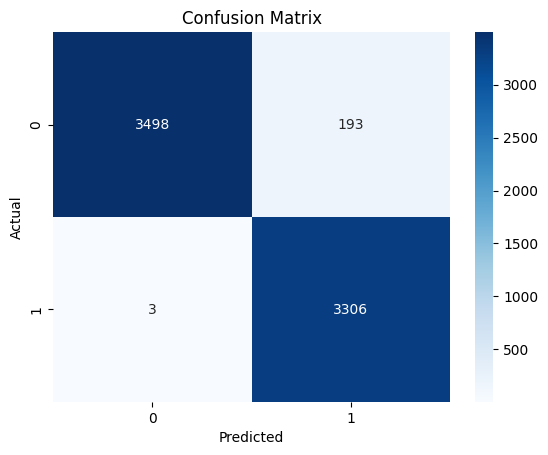

              precision    recall  f1-score   support

           0       1.00      0.95      0.97      3691
           1       0.94      1.00      0.97      3309

    accuracy                           0.97      7000
   macro avg       0.97      0.97      0.97      7000
weighted avg       0.97      0.97      0.97      7000

Epoch 1: Train Loss: 0.0442, Val Loss: 0.0873, Val Acc: 0.9720


Epoch 2/3:   0%|          | 0/3938 [00:00<?, ?it/s]<ipython-input-6-c905cba8746e>:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Enable fp16 precision
Epoch 2/3: 100%|██████████| 3938/3938 [16:33<00:00,  3.96it/s]


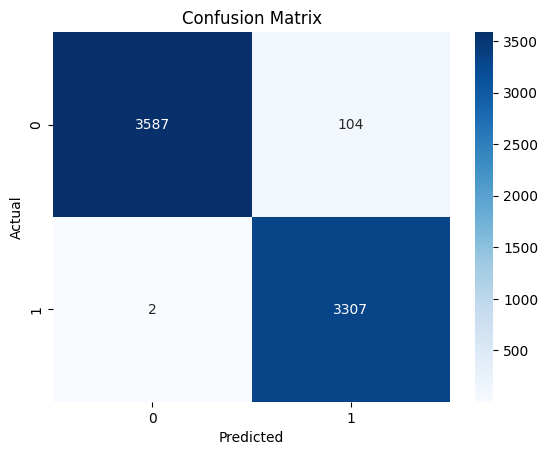

              precision    recall  f1-score   support

           0       1.00      0.97      0.99      3691
           1       0.97      1.00      0.98      3309

    accuracy                           0.98      7000
   macro avg       0.98      0.99      0.98      7000
weighted avg       0.99      0.98      0.98      7000

Epoch 2: Train Loss: 0.0115, Val Loss: 0.0463, Val Acc: 0.9849


Epoch 3/3:   0%|          | 0/3938 [00:00<?, ?it/s]<ipython-input-6-c905cba8746e>:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Enable fp16 precision
Epoch 3/3: 100%|██████████| 3938/3938 [16:33<00:00,  3.96it/s]


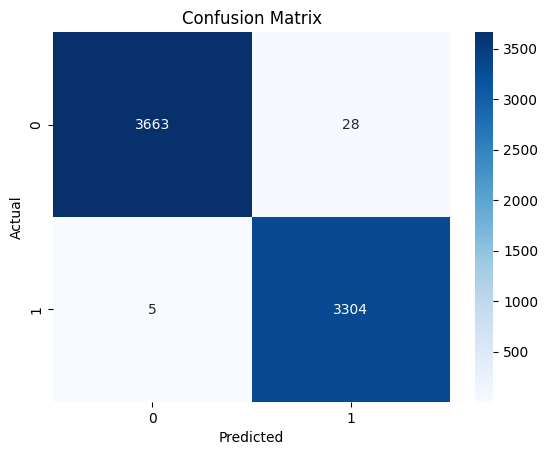

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3691
           1       0.99      1.00      1.00      3309

    accuracy                           1.00      7000
   macro avg       1.00      1.00      1.00      7000
weighted avg       1.00      1.00      1.00      7000

Epoch 3: Train Loss: 0.0107, Val Loss: 0.0284, Val Acc: 0.9953


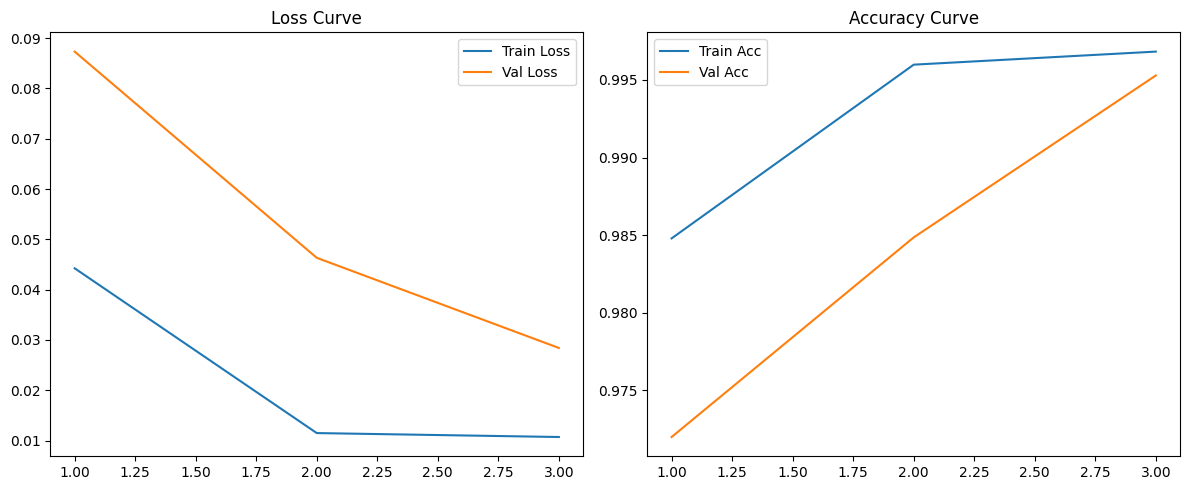

In [13]:
model = RobertaClassifier(num_classes=2)
train_model(model, train_loader, val_loader, epochs=3)

# Predict and save model

In [14]:

predict_and_save(model, X_test, test_ids)


Predicting: 100%|██████████| 30000/30000 [06:08<00:00, 81.41it/s]

Saved predictions to submission.csv


# Save Features and Train XGBoost model

Extracting RoBERTa embeddings for XGBoost...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Extracting features: 100%|██████████| 63000/63000 [12:48<00:00, 82.00it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Extracting features: 100%|██████████| 7000/7000 [01:25<00:00, 81.80it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predic

Saved features to CSV.
XGBoost Evaluation:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      3691
         1.0       0.99      0.99      0.99      3309

    accuracy                           0.99      7000
   macro avg       0.99      0.99      0.99      7000
weighted avg       0.99      0.99      0.99      7000



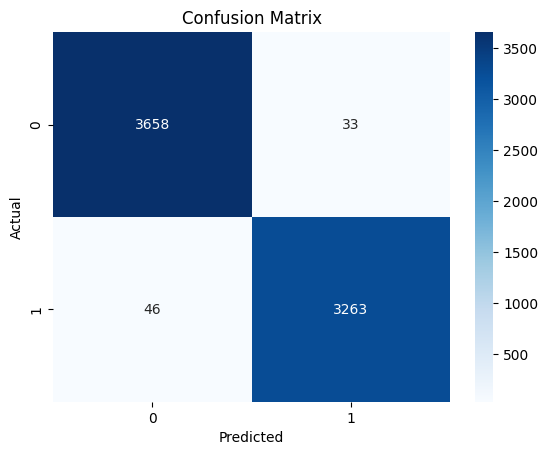

Saved XGBoost predictions to submission_xgboost.csv


In [15]:
save_features_and_train_xgboost(X_train, y_train, X_val, y_val, X_test, test_ids)